# Double blind or single blind?
Scientists' lives revolve around publishing their work in scientific journals. The review  process of article manuscripts can sometimes take from months up to even two years. Getting rejected after that can be quite demoralising, especially when the author feels that the critique of their paper is not fair.

Double blind peer reviews are often used in journals to make reviews more fair and less biased. Double blind means that the author does not know who is reviewing their work and the reviewer also does not know whose work they are reviewing. This helps to reduce the bias in reviewing, encourages early career scientists who are not renowned yet and can promote more objective critique.

Recently, few major journals have come under scrutiny, when rumours started spreading that they are not doing double-blind reviews anymore and are playing dirty. This would mean the reviewers would have full access to the information about the author of the manuscript under review which could directly influence their decision whether to accept the paper or not.

### Your Task
You have access to a simulated dataset that mirrors yearly submission logs from two data science journals. Articles in the dataset are randomly distributed among two independent journals. The articles in both journals contain some popular and some less popular data science topics that are overlapping between the journals. Your goal is to use Bayesian modeling to answer the following questions:

**What factors influence whether a paper gets accepted?**

**Which journal, if any, appears to be biased — for example, favoring well-known authors?**

## Data structure

Each row represents a paper submission. The following variables are available:

**The author's reputation**: Measured by the h-index. The dataset provides the maximum h-index among the authors of each paper.

**Journal id**: In the logs there are 2 different journals. You need to determine which one is biased (i.e., not double-blind).

**The writing quality of the paper**: A score (0–100) based on clarity, grammar, and structure

**The topic/domain of the article**: Keep in mind, that some topics are more popular than others, which could affect the acceptance rate of the journal. Additionally, different journals may favor different topics.

**The final acceptance decision**: A binary indicator showing whether the paper was accepted (1) or rejected (0)


In [15]:
import pandas as pd

data = pd.read_csv('./peer_review.csv')
data.head()

paper_id journal       paper_topic  max_h-index  writing_quality  accepted
0         1       B  Gaussian Process           28              100         0
1         2       B               NLP            7               72         0
2         3       B   Neural Networks           17               72         0
3         4       A               NLP           29               81         0
4         5       A               NLP           19               86         1

In [16]:
data["paper_id"].nunique(), data.shape, data["paper_topic"].unique()

(1000,
 (1000, 6),
 array(['Gaussian Process', 'NLP', 'Neural Networks', 'Bayes',
        'Linear regression'], dtype=object))

## Data modification

* Drop *paper_id* column as it seems to just serve as an index.
* Convert *journal* and *paper_topic* into categorical variables.

In [17]:
data = data.drop(columns=["paper_id"])

data["paper_topic_idx"] = data["paper_topic"].astype("category").cat.codes
data["journal_idx"] = data["journal"].astype("category").cat.codes

data.rename(columns={"max_h-index": "max_h_index"}, inplace=True)

t_dict = {}

data.head()

journal       paper_topic  max_h_index  writing_quality  accepted  \
0       B  Gaussian Process           28              100         0   
1       B               NLP            7               72         0   
2       B   Neural Networks           17               72         0   
3       A               NLP           29               81         0   
4       A               NLP           19               86         1   

   paper_topic_idx  journal_idx  
0                1            1  
1                3            1  
2                4            1  
3                3            0  
4                3            0

## Model creation
### Model 1

Let's start with a full linear model, assuming no confounders. 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_writing, beta_h_index, beta_journal, beta_topic]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


Output()

Sampling: [accepted]


Output()

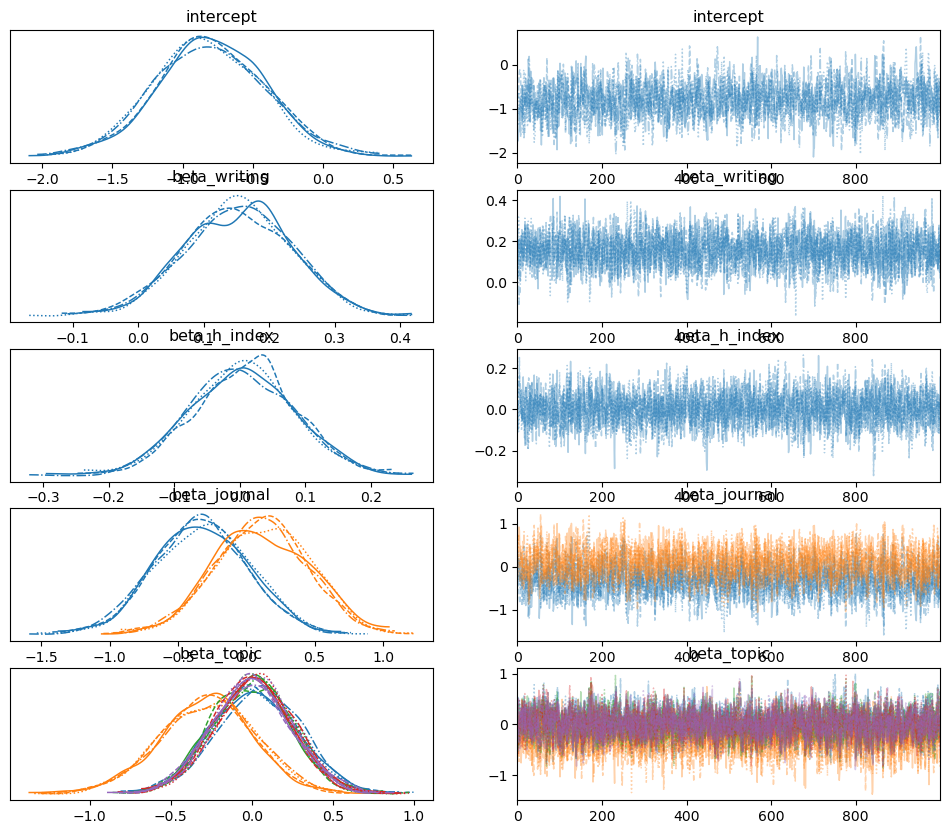

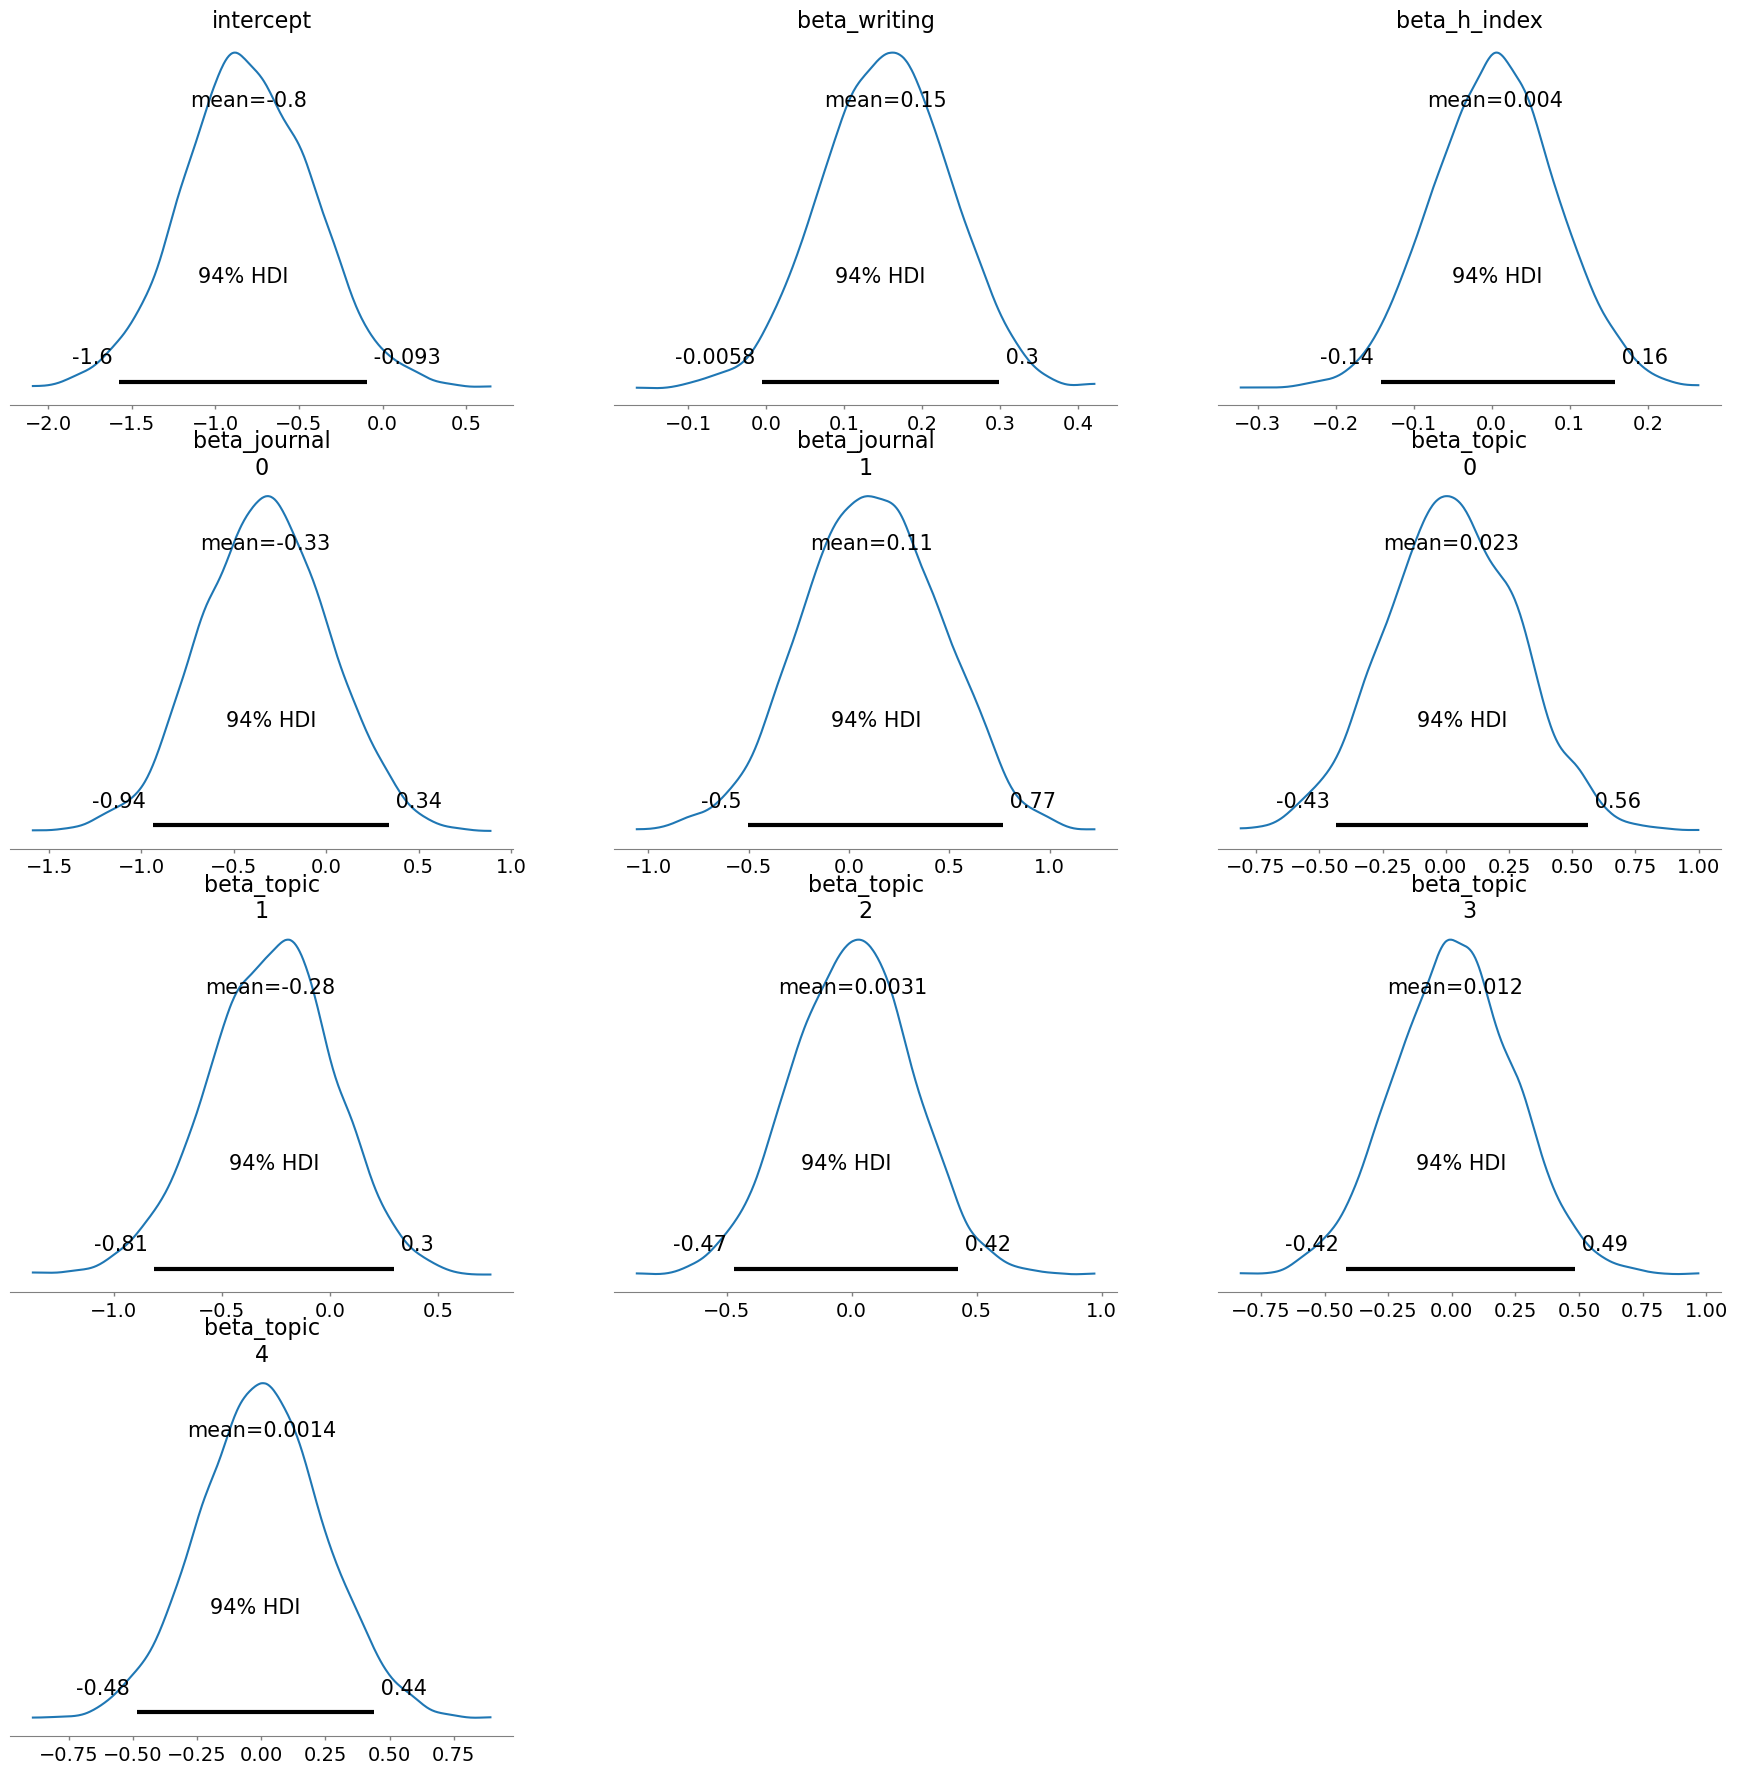

In [18]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

journal_idx = data.journal_idx.values.astype(int)
topic_idx = data.paper_topic_idx.values.astype(int)
writing_quality = data.writing_quality.values
h_index = data.max_h_index.values
accepted = data.accepted.values

# Standardize and normalise writing quality and h_index
w = (data.writing_quality - data.writing_quality.mean()) / data.writing_quality.std()
h = (data.max_h_index   - data.max_h_index.mean())   / data.max_h_index.std()

with pm.Model() as model1:
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_writing = pm.Normal("beta_writing", mu=0, sigma=0.5)
    beta_h_index = pm.Normal("beta_h_index", mu=0, sigma=0.5)
    # Different journals and different topics should have different chances of acceptance
    beta_journal = pm.Normal("beta_journal", mu=0, sigma=0.5, shape=len(np.unique(data.journal)))
    beta_topic = pm.Normal("beta_topic", mu=0, sigma=0.5, shape=len(np.unique(data.paper_topic)))


    logits = (
        intercept
        + beta_writing * w 
        + beta_h_index * h
        + beta_journal[journal_idx]
        + beta_topic[topic_idx]
    )

    pm.Bernoulli("accepted", logit_p=logits, observed=accepted)

    trace = pm.sample(tune=2000, target_accept=0.9)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict["model1"] = trace

pm.summary(trace)
pm.plot_trace(trace)
pm.plot_posterior(trace)
plt.show()


A couple of takeaways:
* Better writing quality seems to correlate with a higher chance of acceptance. 
* Journal A seems to be tougher to get published in. 
* Model 1 seems to indicate that h-index does not directly change outcomes. 
* The least popular topic seems to be Gaussian Process. 

### Model 2

Let's try a model where h-index may influence the journal chosen for submission and writing quality - maybe more popular scientists write better and maybe some journals are "h-index hacking".

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_writing, beta_h_index, beta_journal, beta_h_journal, beta_h_writing]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


Output()

Sampling: [accepted]


Output()

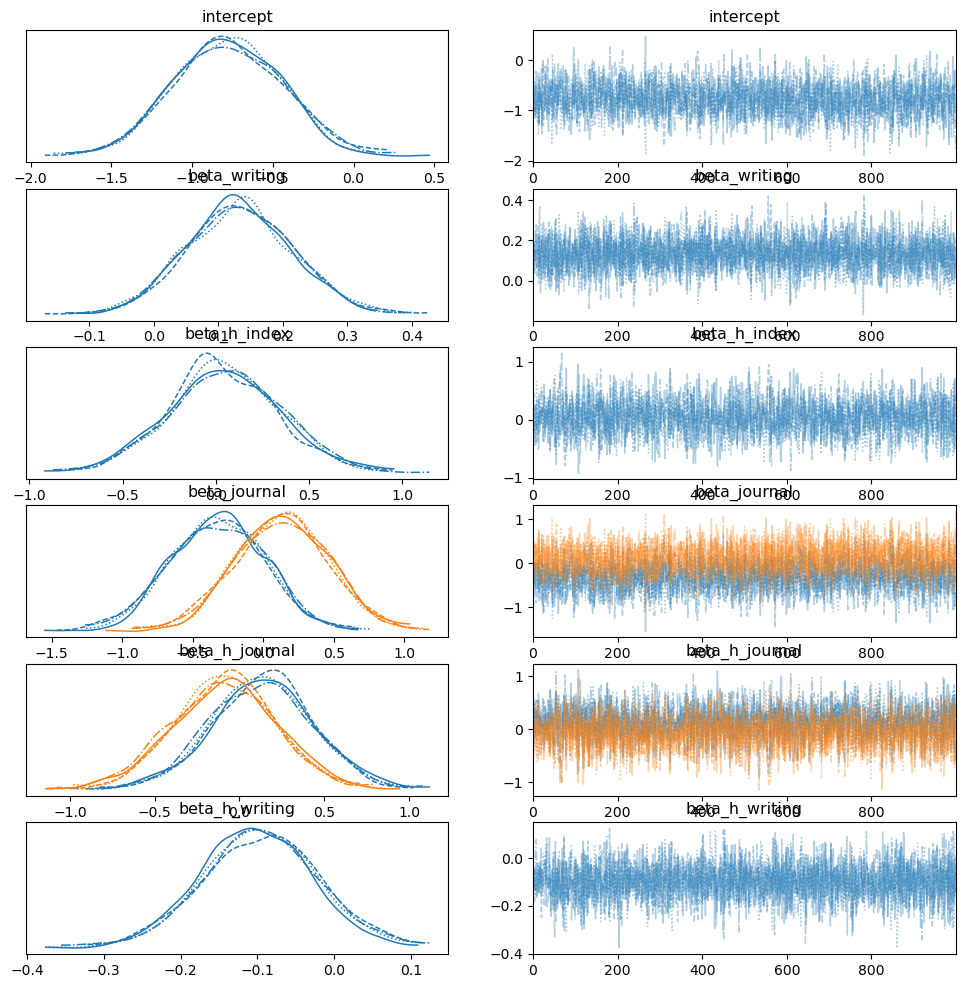

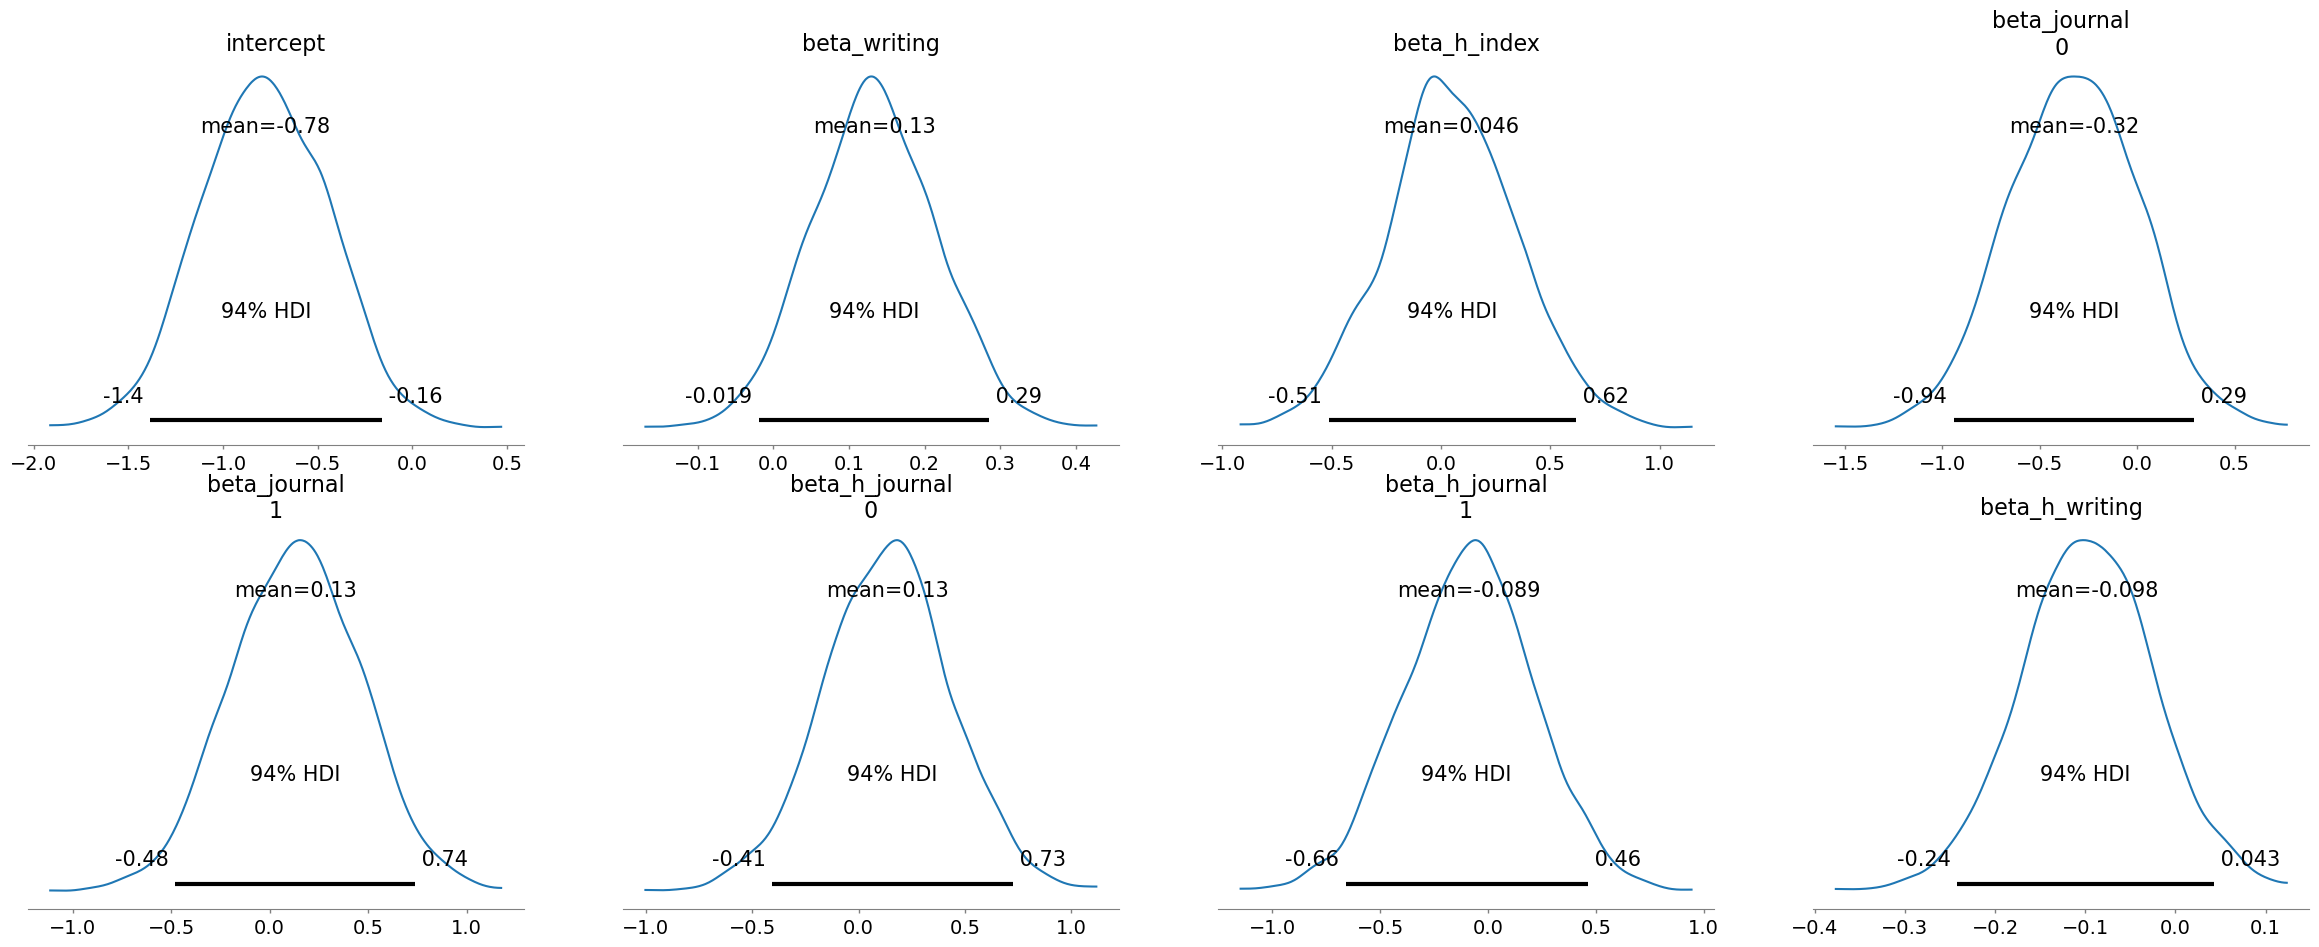

In [19]:
with pm.Model() as model2:
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_writing = pm.Normal("beta_writing", mu=0, sigma=0.5)
    beta_h_index = pm.Normal("beta_h_index", mu=0, sigma=0.5)
    beta_journal = pm.Normal("beta_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))
    beta_h_journal = pm.Normal("beta_h_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))
    beta_h_writing = pm.Normal("beta_h_writing", mu=0, sigma=0.5)

    logits = (
        intercept
        + beta_writing * w
        + beta_h_index * h
        + beta_journal[journal_idx]
        + beta_h_journal[journal_idx] * h
        + beta_h_writing * w * h
    )

    pm.Bernoulli("accepted", logit_p=logits, observed=accepted)

    trace = pm.sample(tune=2000, target_accept=0.9)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict["model2"] = trace

pm.summary(trace)
pm.plot_trace(trace)
pm.plot_posterior(trace)
plt.show()


A couple of takeaways:
* There doesn't seem to be a strong correlation between h-index and writing quality. 
* The more selective journal A seems to be favoring scientists with higher h-indexes. 

### Model 3

Let's also take a look if there is a confounder between writing and journal.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_writing, beta_h_index, beta_journal, beta_h_journal, beta_h_writing, beta_writing_journal]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.


Output()

Sampling: [accepted]


Output()

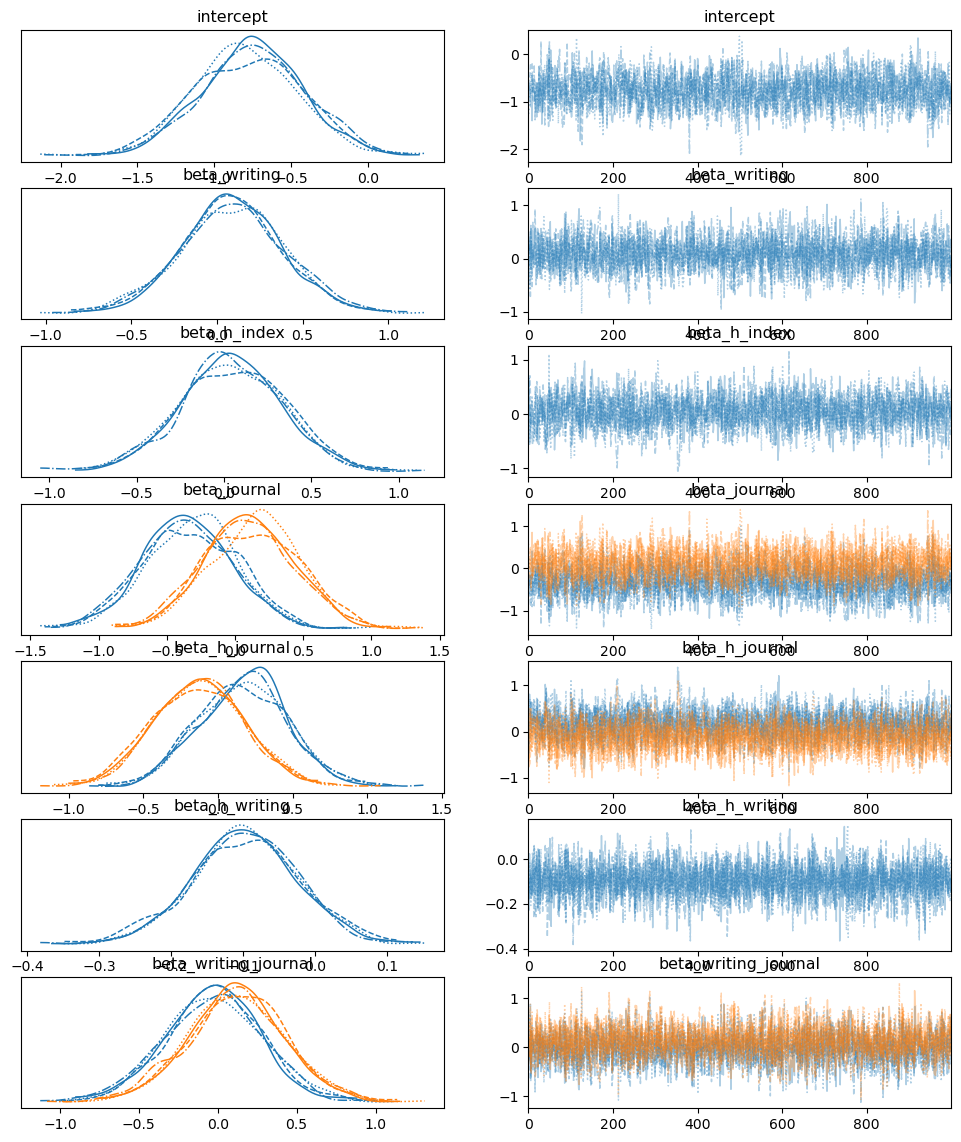

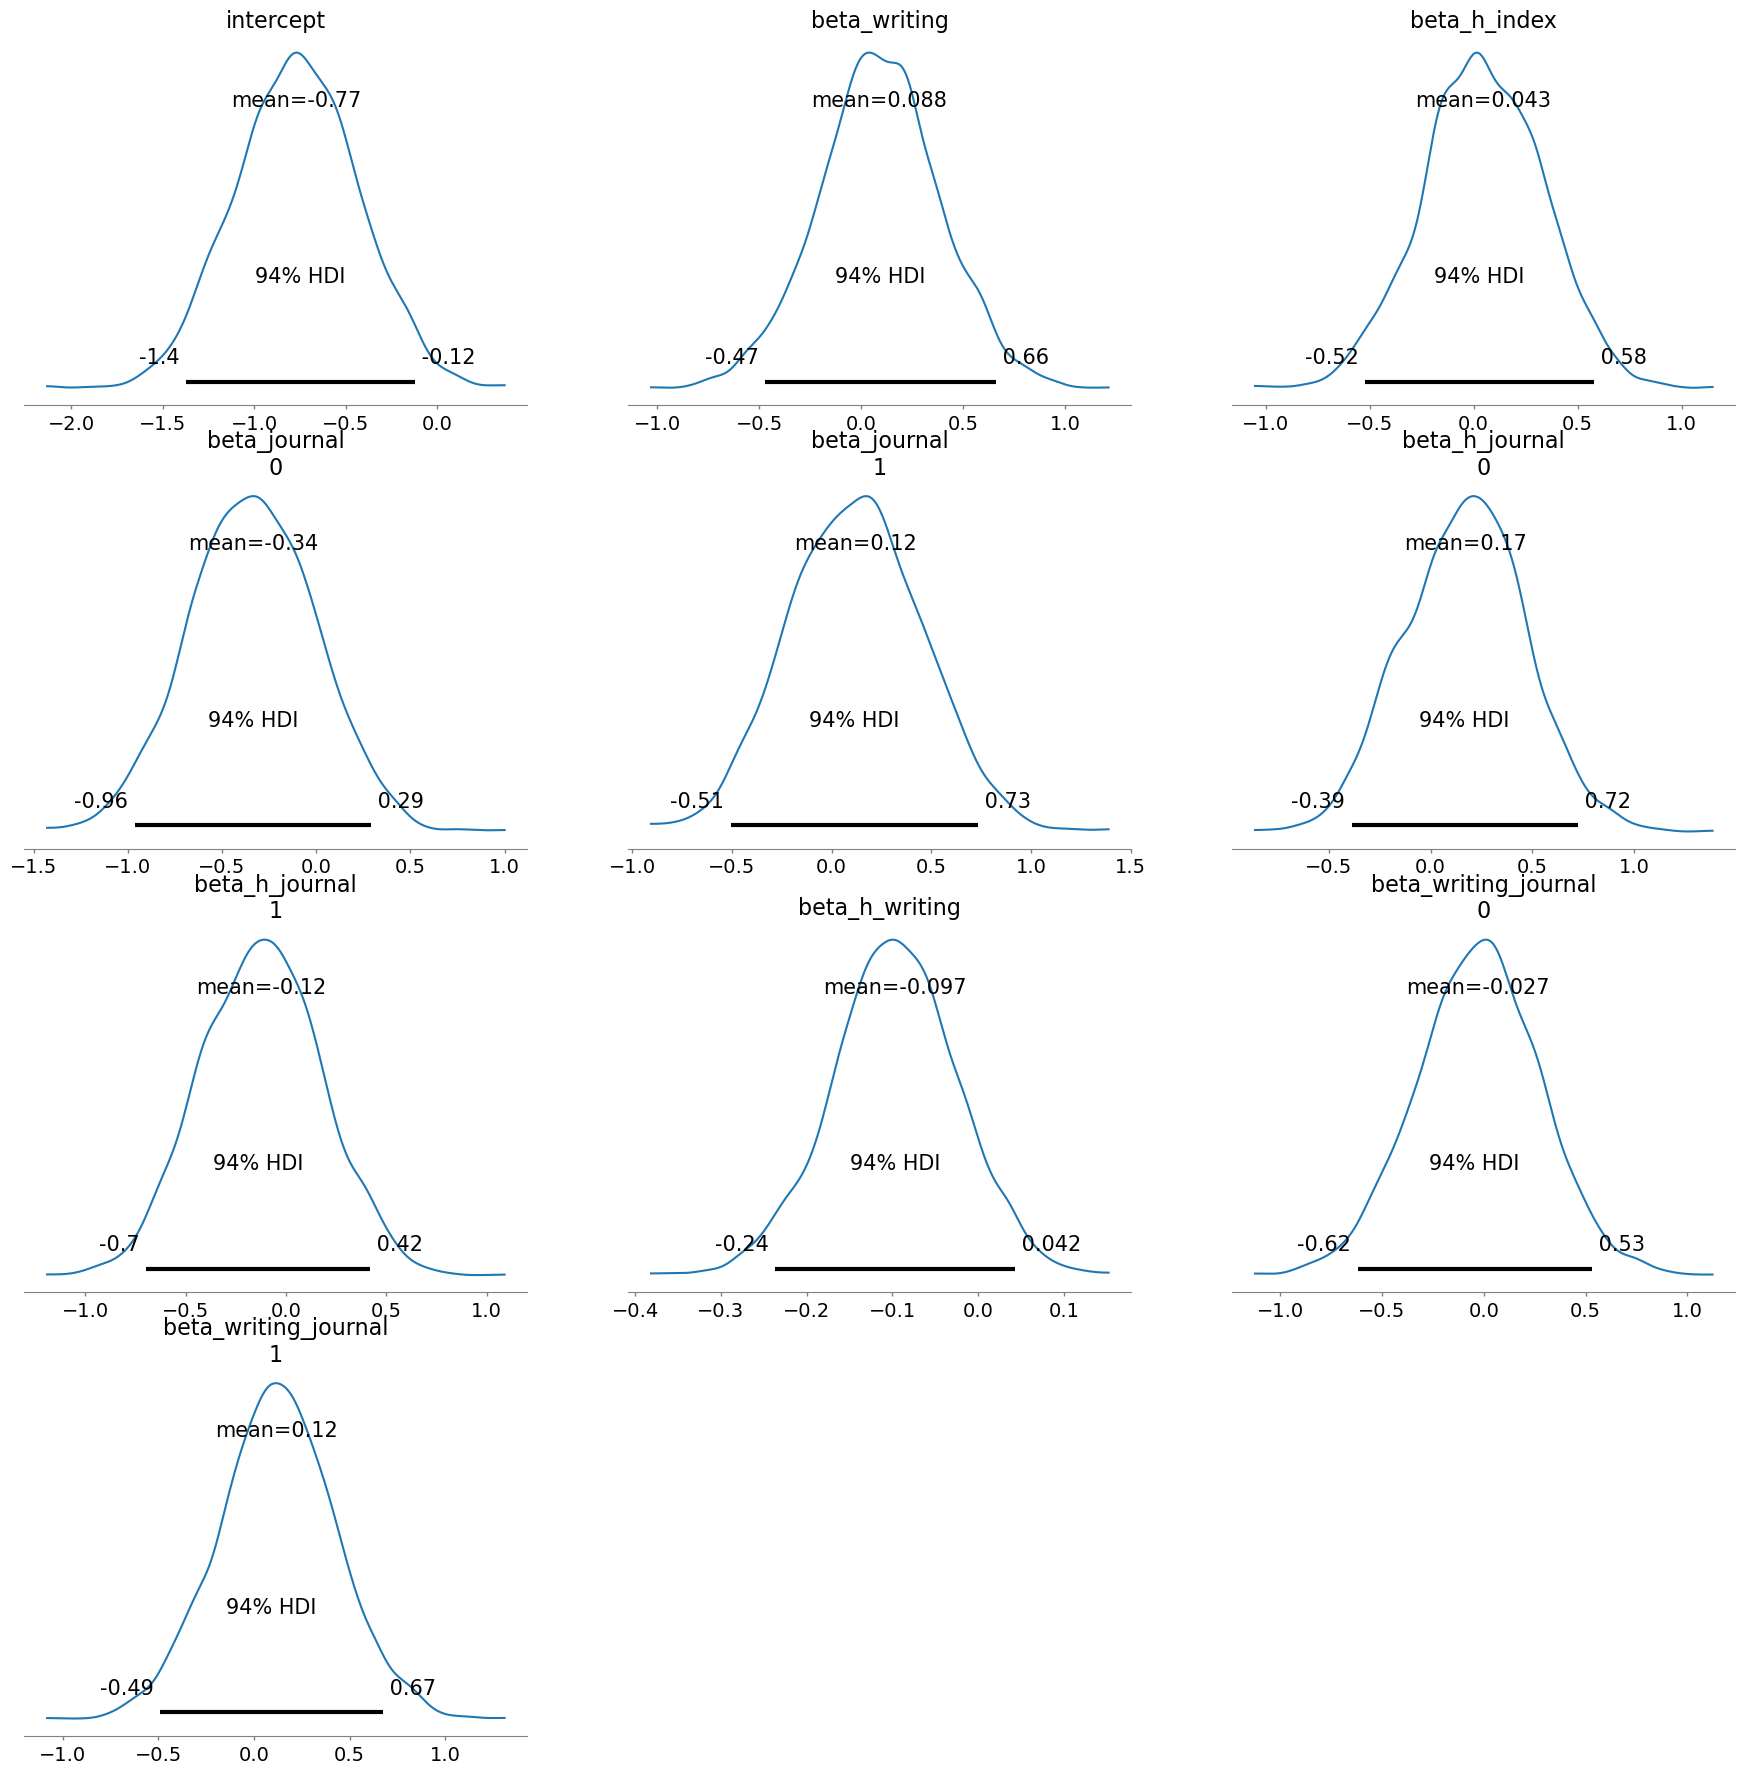

In [20]:
with pm.Model() as model3:
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_writing = pm.Normal("beta_writing", mu=0, sigma=0.5)
    beta_h_index = pm.Normal("beta_h_index", mu=0, sigma=0.5)
    beta_journal = pm.Normal("beta_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))
    beta_h_journal = pm.Normal("beta_h_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))
    beta_h_writing = pm.Normal("beta_h_writing", mu=0, sigma=0.5)
    beta_writing_journal = pm.Normal("beta_writing_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))

    logits = (
        intercept
        + beta_writing * w
        + beta_h_index * h
        + beta_journal[journal_idx]
        + beta_h_journal[journal_idx] * h
        + beta_h_writing * w * h
        + beta_writing_journal[journal_idx] * w
    )

    pm.Bernoulli("accepted", logit_p=logits, observed=accepted)

    trace = pm.sample(tune=2000, target_accept=0.9)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict["model3"] = trace

pm.summary(trace)
pm.plot_trace(trace)
pm.plot_posterior(trace)

plt.show()


Takeaways:
* Journal A seems to prefer authors with higher h-indexes; writing quality does not have significant influence.
* Journal B seems to prefer higher writing quality; h-index does not seem to have significant influence. 

### Model 4

Let's also try to factor in how different journals can prefer different topics.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_writing, beta_h_index, beta_journal, beta_h_journal, beta_h_writing, beta_writing_journal, beta_topic, beta_topic_journal, beta_topic_writing]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.


Output()

Sampling: [accepted]


Output()

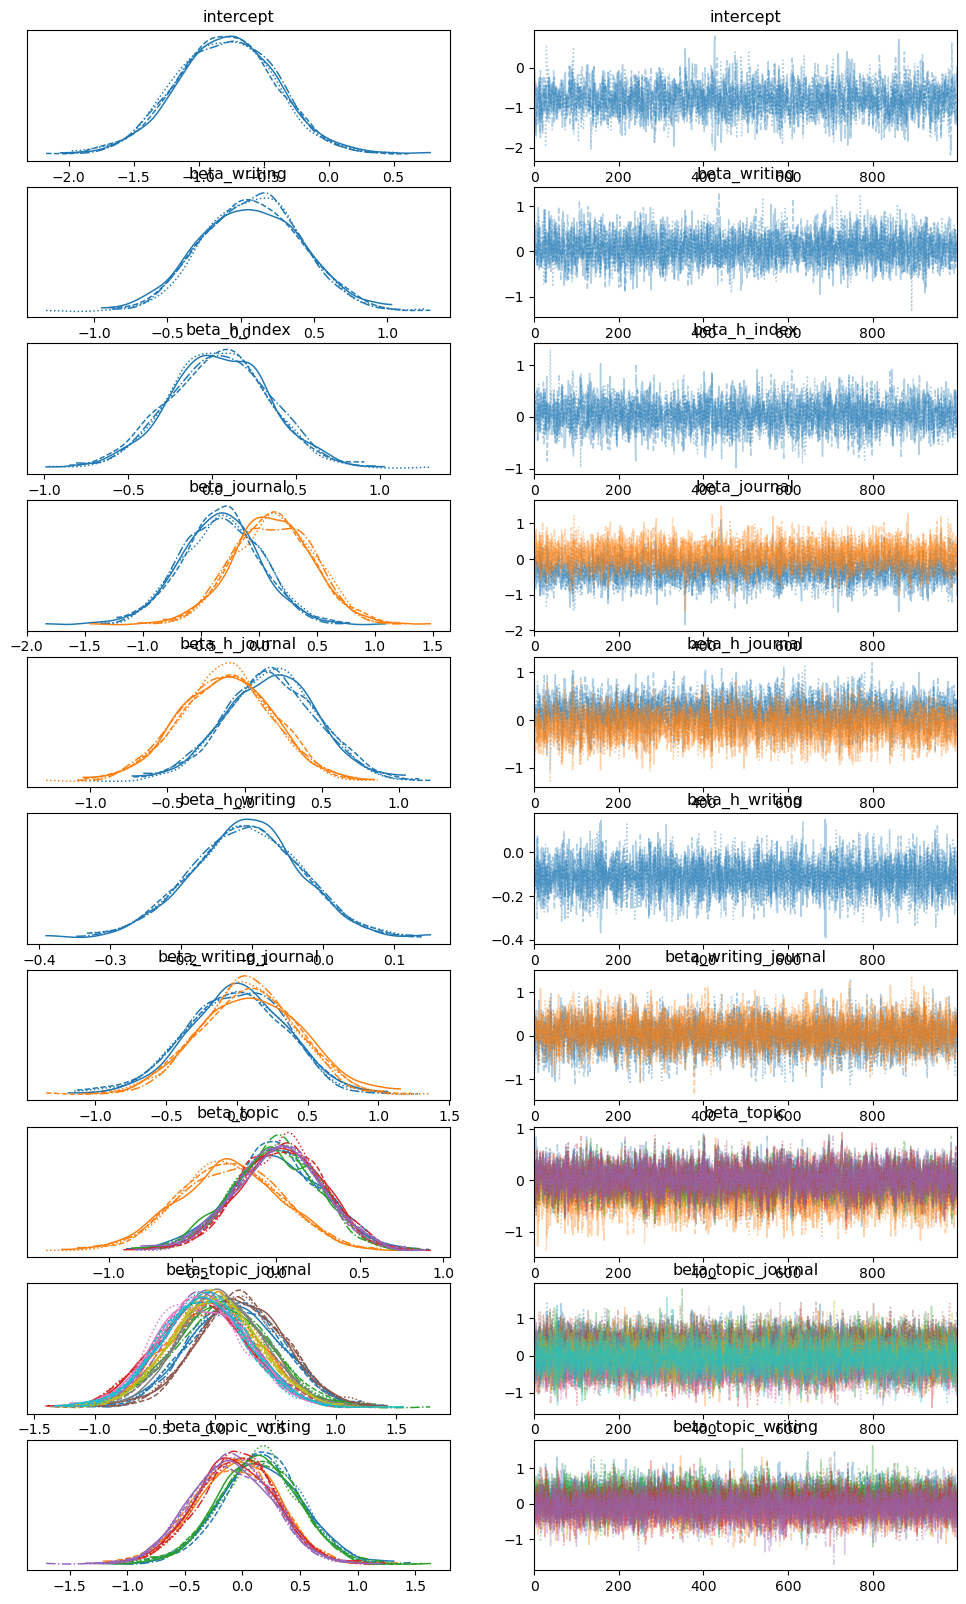

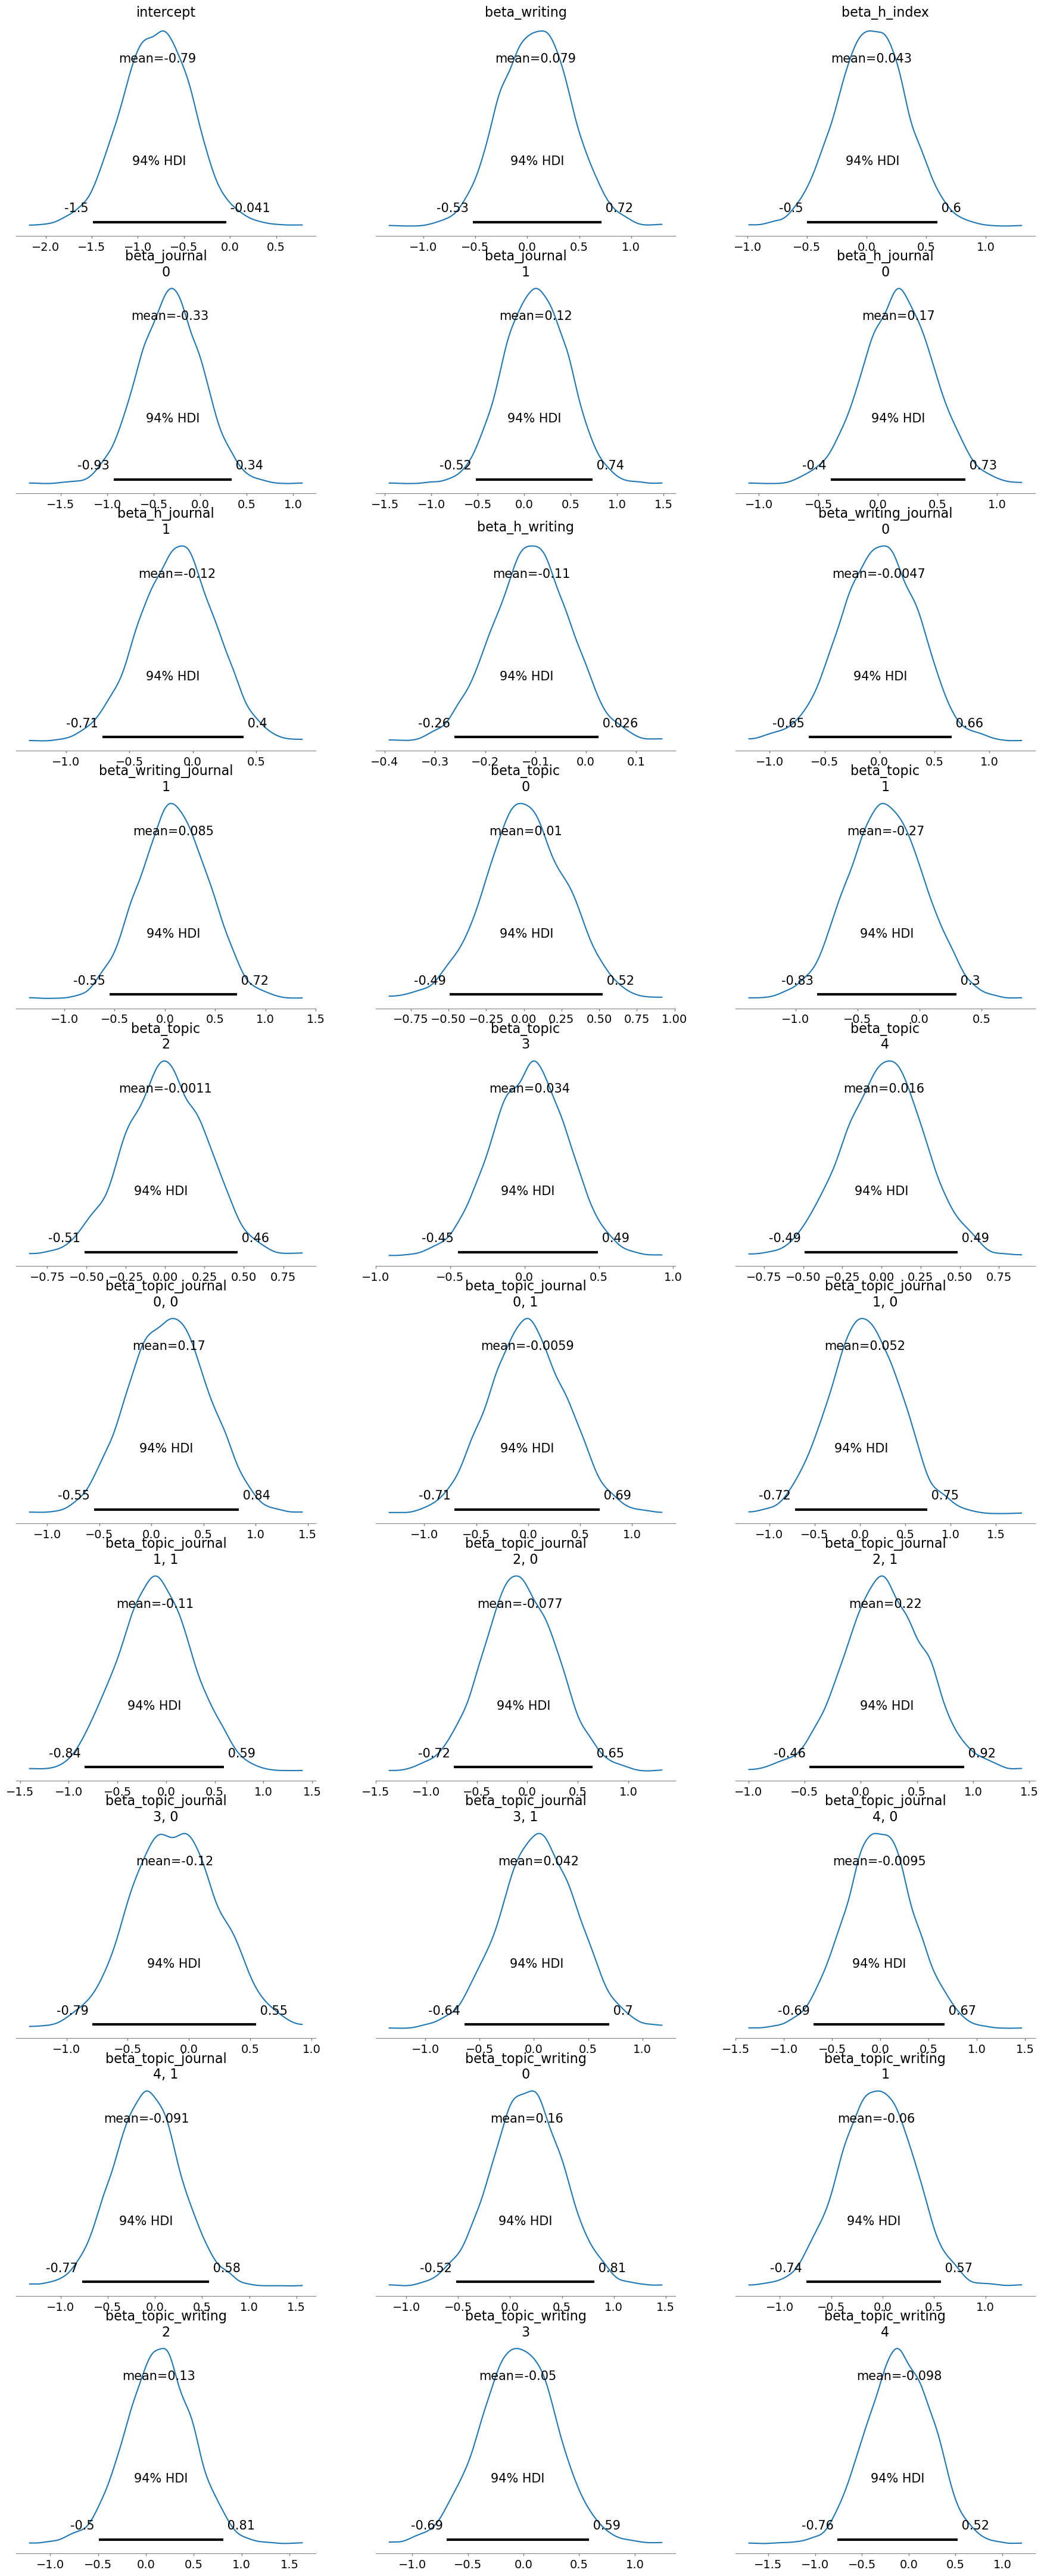

In [21]:
with pm.Model() as model4:
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_writing = pm.Normal("beta_writing", mu=0, sigma=0.5)
    beta_h_index = pm.Normal("beta_h_index", mu=0, sigma=0.5)
    beta_journal = pm.Normal("beta_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))
    beta_h_journal = pm.Normal("beta_h_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))
    beta_h_writing = pm.Normal("beta_h_writing", mu=0, sigma=0.5)
    beta_writing_journal = pm.Normal("beta_writing_journal", mu=0, sigma=0.5, shape=len(np.unique(journal_idx)))
    beta_topic = pm.Normal("beta_topic", mu=0, sigma=0.5, shape=len(np.unique(topic_idx)))
    beta_topic_journal = pm.Normal("beta_topic_journal", mu=0, sigma=0.5, shape=(len(np.unique(topic_idx)), len(np.unique(journal_idx))))
    beta_topic_writing = pm.Normal("beta_topic_writing", mu=0, sigma=0.5, shape=len(np.unique(topic_idx)))

    logits = (
        intercept
        + beta_writing * w
        + beta_h_index * h
        + beta_journal[journal_idx]
        + beta_h_journal[journal_idx] * h
        + beta_h_writing * w * h
        + beta_writing_journal[journal_idx] * w
        + beta_topic[topic_idx]
        + beta_topic_journal[topic_idx, journal_idx] * w
        + beta_topic_writing[topic_idx] * w
    )

    pm.Bernoulli("accepted", logit_p=logits, observed=accepted)

    trace = pm.sample(tune=2000, target_accept=0.9)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict["model4"] = trace

pm.summary(trace)
pm.plot_trace(trace)
pm.plot_posterior(trace)

plt.show()

Takeaways:
* The journals seem to differ in their opinion on topics such as Gaussian Process and Linear regression. 
* Journal A still seems to be the crooked one.

## Model comparison

        rank    elpd_loo      p_loo  elpd_diff        weight         se  \
model2     0 -593.662029   6.114204   0.000000  1.000000e+00  13.671192   
model3     1 -594.112722   7.069233   0.450693  0.000000e+00  13.721228   
model1     2 -596.499203   7.582262   2.837174  3.414763e-16  13.625592   
model4     3 -600.381186  17.880303   6.719157  1.110223e-16  14.167808   

             dse  warning scale  
model2  0.000000    False   log  
model3  0.927086    False   log  
model1  2.223640    False   log  
model4  3.179815    False   log  


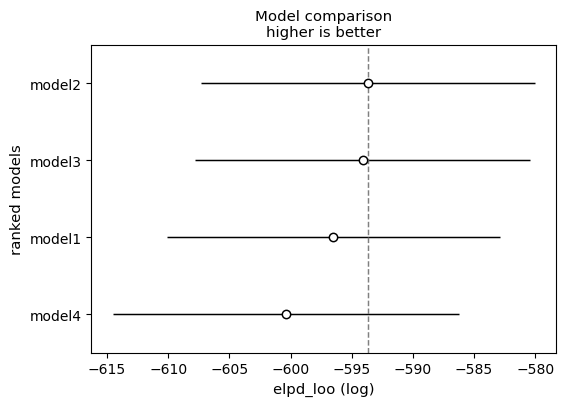

In [23]:
c = az.compare(t_dict)
print(c)
az.plot_compare(c, textsize=10)
plt.show()

Seems like incorporating a confounder between the journal and the topic makes the prediction worse. The best-performing method of the four was the one that incorporated h-index's effect on the journal and not much else, though all were reasonably equal.

## Conclusions

* Journal A is the one that peeks at the h-indices and journal B seems to be the honest one. 
* According to model 4, Gaussian Process is not a good topic if you're looking to get your paper published.
* The simpler models that didn't take the paper topic into account were just as good at predicting the acceptance rate

## DAG of the most accurate model

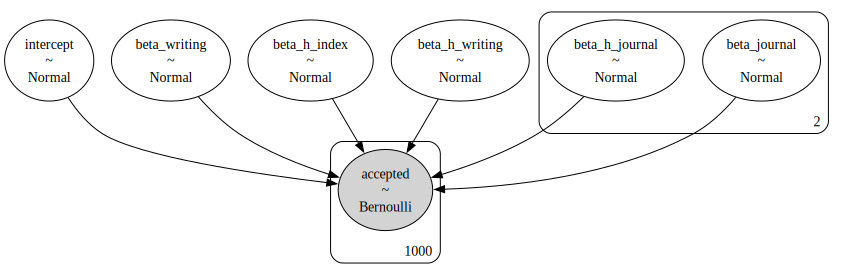

In [26]:
pm.model_to_graphviz(model2)